In [1]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd

In [2]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [3]:
import numpy as np
from scipy.spatial import KDTree

def remove_low_density_points(points, radius=0.1, min_neighbors=3):
    tree = KDTree(points)
    distances, _ = tree.query(points, k=min_neighbors, distance_upper_bound=radius)
    mask = np.all(distances < radius, axis=1)
    return mask #(N,3)

def remove_low_intensity_points(points):
    intensity_mean, intensity_std = np.mean(points), np.std(points)
    lower_threshold = intensity_mean - 2 * intensity_std
    upper_threshold = intensity_mean + 2 * intensity_std
    mask = (points > lower_threshold) & (points < upper_threshold)
    return mask

In [5]:
METHOD = 'mean'
POOL_NAME = '2B'
FRECUENCY = '100kHz'    
PROJECT_NAME = f'250111-100kHz_120m'
PATH_LAS = f'data/{FRECUENCY}/{PROJECT_NAME}/{POOL_NAME}/{POOL_NAME}_clasificada_col_0_row_0_sqm.las'
print(PATH_LAS)
OUTPUTS_PATH = f'discrete_model/{METHOD}/{PROJECT_NAME}/{POOL_NAME}'
LIMIT = -1

if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

data/100kHz/250111-100kHz_120m/2B/2B_clasificada_col_0_row_0_sqm.las


In [6]:
bottom_pools = {'RBS': 2300.26, 'RBN': 2300.46, '1B': 2300.54, 
               '2B': 2300.48, '4A': 2300.24, 'H13': 2300.05, 
               'H14': 2300.24, 'H15': '2300.01', 'H16': 2299.85, 
               'H17': 2299.24, 'K51': '2300.49', 'K52': 2300.46, 
               'K53': 2300.41, 'K54': '2300.38', 'HK13': 2300.77, 
               'HK14': 2300.54, 'K36': '2300.89', 'K37': 2300.51, 
               '9F': 2300.30, '9E': 2300.27, '11G': 2300.33, 
               '11F': 2300.27, '11JC': 2300.30, '10J': 2300.35, 
               '10I': 2300.18, '10H': 2300.34}

bottom_pool = bottom_pools.get(POOL_NAME, '')
print(bottom_pool)

2300.48


In [7]:
# Lectura del archivo las
las = read_las_file(PATH_LAS)

# Print de las dimensiones y atributos que tiene el archivo las
for dimension in las.point_format.dimensions:
    print(dimension.name)

X
Y
Z
intensity
return_number
number_of_returns
synthetic
key_point
withheld
overlap
scanner_channel
scan_direction_flag
edge_of_flight_line
classification
user_data
scan_angle
point_source_id
gps_time
red
green
blue
Amplitude
Reflectance
Deviation


In [8]:
points = np.vstack((las.x, las.y, las.z)).transpose()
colors = np.vstack((las.red, las.green, las.blue)).transpose()
colors_norm = normalize_colors(colors)
points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(points)  
bottom_pool_norm = (bottom_pool - z_min) / (z_max - z_min)
# En este stack, el indice -1 es el número de retornos, el -2 es el número de retorno y el -3 es la intensidad
data_points = np.hstack((points,
                         points_norm,
                         colors,
                         colors_norm,
                         np.expand_dims(las.Deviation, -1),
                         np.expand_dims(las.intensity, -1),
                         np.expand_dims(las.return_number, -1),
                         np.expand_dims(las.number_of_returns, -1)))

# Filtro de puntos basados en la rasante facilitada por SQM
# No pueden haber puntos por debajo de la rasante
data_points = data_points[data_points[:,2] > bottom_pool]

In [9]:
original_plotter = pv.Plotter()
original_plotter.add_points(data_points[:,3:6], scalars=data_points[:,9:12], rgb = True, point_size=1)
original_plotter.show()

Widget(value='<iframe src="http://localhost:33657/index.html?ui=P_0x7aa5bcb683e0_0&reconnect=auto" class="pyvi…

In [10]:
def find_best_gmm(data, max_components=2, criterion='bic', **kwargs):
    '''
    Find the best number of components for a Gaussian Mixture Model using AIC or BIC. 
    '''

    n_components_range = range(1, max_components + 1)
    criterions, means, weights, std = [], [], [], []

    if criterion not in ['aic', 'bic']:
        raise ValueError("Invalid criterion. Use 'bic' or 'aic'.")

    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            if criterion == 'bic':
                criterions.append(gmm.bic(data))
            else:
                criterions.append(gmm.aic(data))

            weights_mask = gmm.weights_ > 0.01
            means.append(gmm.means_[weights_mask])
            weights.append(gmm.weights_[weights_mask])
            std.append(np.sqrt(gmm.covariances_[weights_mask]))

        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    return n_components_range[np.argmin(criterions)], means[np.argmin(criterions)], weights[np.argmin(criterions)], std[np.argmin(criterions)]

In [11]:
def find_gmm(data, n_components, criterion='bic', **kwargs):
    '''
    Find the best number of components for a Gaussian Mixture Model using AIC or BIC. 
    '''
    means, weights, std = [], [], []

    if criterion not in ['aic', 'bic']:
        raise ValueError("Invalid criterion. Use 'bic' or 'aic'.")

    try:
        gmm = GaussianMixture(n_components=n_components, **kwargs)
        gmm.fit(data)
        weights_mask = gmm.weights_ > 0.01
        means.append(gmm.means_[weights_mask])
        weights.append(gmm.weights_[weights_mask])
        std.append(np.sqrt(gmm.covariances_[weights_mask]))

    except ValueError as e:
        print(f"Error fitting GMM with {n_components} components: {e}")
        return None

    return means[0], weights[0], std[0]

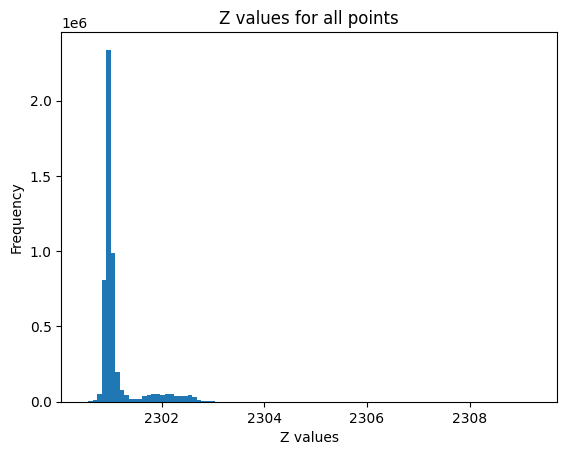

In [12]:
index = 2
# plot of z values
plt.hist(data_points[:,index], bins=100)
plt.title('Z values for all points')
plt.xlabel('Z values')
plt.ylabel('Frequency')
plt.show()

In [13]:
#data_z_comps, data_z_means, data_z_weights, data_z_std = find_best_gmm(data_points[:,index].reshape(-1, 1), max_components=3)
data_z_means, data_z_weights, data_z_std = find_gmm(data_points[:,index].reshape(-1, 1), n_components=3)

In [14]:
data_z_means[0]

array([2301.59948988])

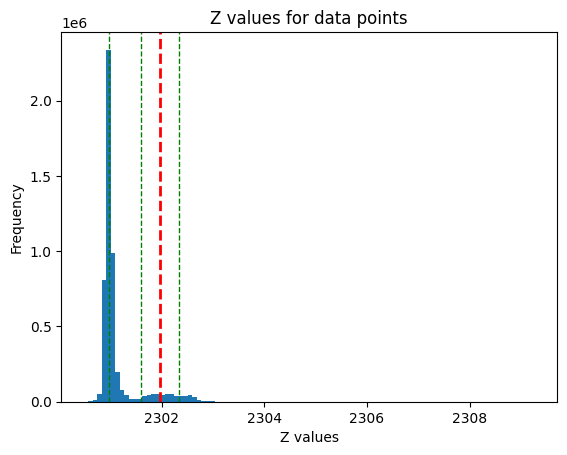

In [15]:
# plot medians of the gaussian components
plt.hist(data_points[:,index], bins=100)
plt.title('Z values for data points')
# plot all medians
for mean in data_z_means:
    plt.axvline(mean, color='green', linestyle='dashed', linewidth=1)
# plot median of bigger component
sorted_data_points_z_mean, sorted_data_points_z_std = zip(*sorted(zip(data_z_means, data_z_std), key=lambda x: x[0]))
higher_mean = sorted_data_points_z_mean[-1]
salmuera_mean = sorted_data_points_z_mean[-2]
data_points_z_best_mean = (higher_mean + salmuera_mean) / 2
plt.axvline(data_points_z_best_mean, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Z values')
plt.ylabel('Frequency')
plt.show()

In [16]:
mask = (data_points[:,index] < [data_points_z_best_mean])
data_points = data_points[mask[0]]

In [17]:
original_plotter = pv.Plotter()
original_plotter.add_points(data_points[:,3:6], scalars=data_points[:,9:12], rgb = True, point_size=1)
original_plotter.show()

Widget(value='<iframe src="http://localhost:33657/index.html?ui=P_0x7aa59faba000_1&reconnect=auto" class="pyvi…

In [18]:
# One return: Puntos asociados a un haz de láser con un solo retorno (1). No lo estoy usando.
one_return = data_points[(data_points[:,-1] == 1)]

# Two returns: Puntos asociados a un haz de láser con dos retornos (2)
# Two returns - 1: Puntos que corresponden al primer retorno de un haz de láser con dos retornos
# Two returns - 2: Puntos que corresponden al segundo retorno de un haz de láser con dos retornos
two_returns_1 = data_points[(data_points[:,-1] == 2) & (data_points[:,-2] == 1)]
two_returns_2 = data_points[(data_points[:,-1] == 2) & (data_points[:,-2] == 2)]

In [19]:
print(f"Total points: {data_points.shape[0]}")
print(f"Points with one return: {one_return.shape[0]}")
print(f"Points with two returns, return 1: {two_returns_1.shape[0]}")
print(f"Points with two returns, return 2: {two_returns_2.shape[0]}")

Total points: 4749312
Points with one return: 4670599
Points with two returns, return 1: 46078
Points with two returns, return 2: 31372


In [20]:
# Definir el plano de la rasante para visualizarlo
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)
Z = np.ones_like(X) * bottom_pool_norm
plane = pv.StructuredGrid(X, Y, Z)

In [21]:
return_plotter = pv.Plotter()
# plot de los puntos asociados a un haz con 2 retornos. Primer retorno en azul, segundo retorno en verde.
return_plotter.add_points(two_returns_1[:,3:6], color = 'blue', point_size=1)
return_plotter.add_points(two_returns_2[:,3:6], color = 'green', point_size=1)
# plot del plano de la rasante
return_plotter.add_mesh(plane, color='grey')
return_plotter.show()

Widget(value='<iframe src="http://localhost:33657/index.html?ui=P_0x7aa57d16a870_2&reconnect=auto" class="pyvi…

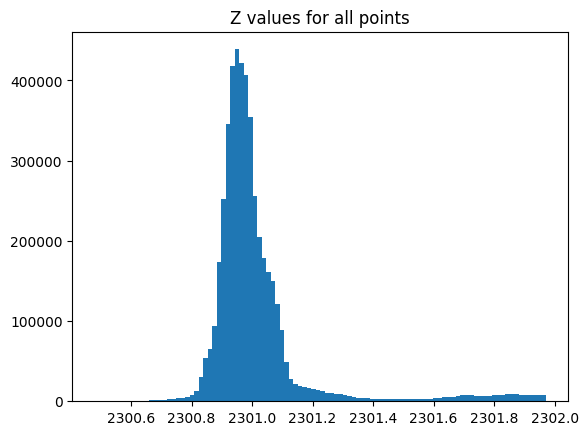

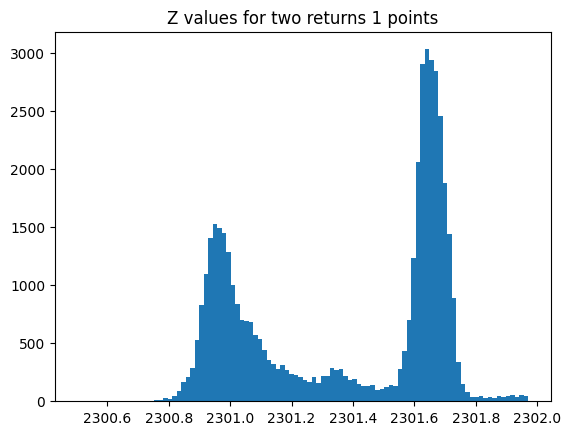

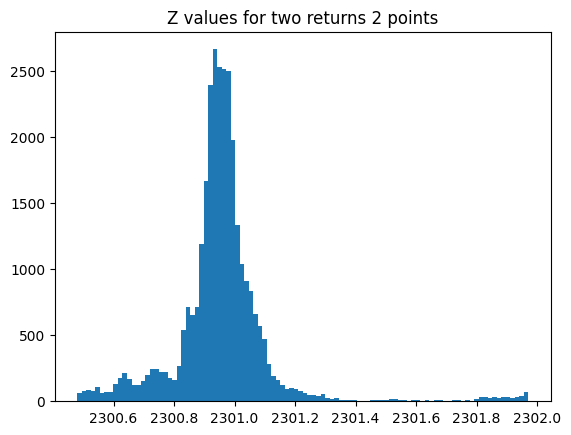

In [22]:
# plot of z values
plt.hist(data_points[:,2], bins=100)
plt.title('Z values for all points')
plt.show()
plt.hist(two_returns_1[:,2], bins=100)
plt.title('Z values for two returns 1 points')
plt.show()
plt.hist(two_returns_2[:,2], bins=100)
plt.title('Z values for two returns 2 points')
plt.show()

In [23]:
# two_returns_1_z_comps, two_returns_1_z_means, two_returns_1_z_weights, two_returns_1_z_std = find_best_gmm(two_returns_1[:,index].reshape(-1, 1), max_components=2)
# two_returns_2_z_comps, two_returns_2_z_means, two_returns_2_z_weights, two_returns_2_z_std = find_best_gmm(two_returns_2[:,index].reshape(-1, 1), max_components=2)
# data_points_z_comps_v2, data_points_z_means_v2, data_points_z_weights_v2, data_points_z_std_v2 = find_best_gmm(data_points[:,index].reshape(-1, 1), max_components=2)
two_returns_1_z_means, two_returns_1_z_weights, two_returns_1_z_std = find_gmm(two_returns_1[:,index].reshape(-1, 1), n_components=3)
two_returns_2_z_means, two_returns_2_z_weights, two_returns_2_z_std = find_gmm(two_returns_2[:,index].reshape(-1, 1), n_components=3)
data_points_z_means_v2, data_points_z_weights_v2, data_points_z_std_v2 = find_gmm(data_points[:,index].reshape(-1, 1), n_components=2)

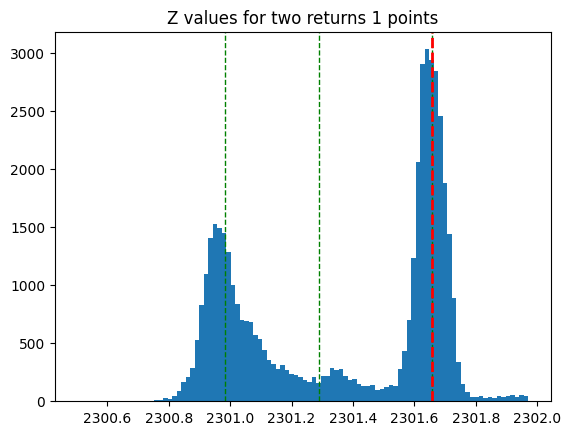

In [24]:
# plot medians of the gaussian components
plt.hist(two_returns_1[:,index], bins=100)
plt.title('Z values for two returns 1 points')
# plot all medians
for mean in two_returns_1_z_means:
    plt.axvline(mean, color='green', linestyle='dashed', linewidth=1)
# plot median of bigger component
two_returns_1_best_mean = two_returns_1_z_means[np.argmax(two_returns_1_z_weights)]
two_returns_1_best_std = two_returns_1_z_std[np.argmax(two_returns_1_z_weights)]
plt.axvline(two_returns_1_best_mean, color='red', linestyle='dashed', linewidth=2)
plt.show()

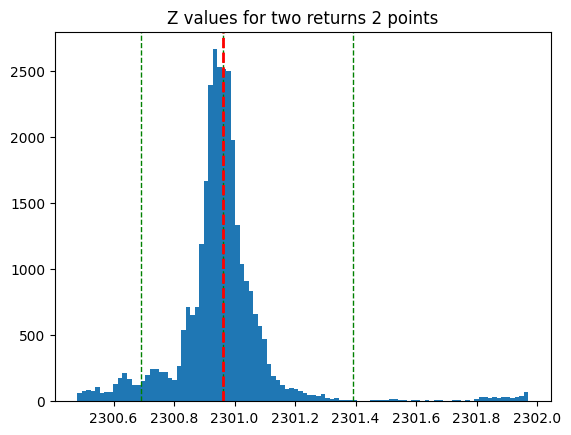

In [25]:
# plot medians of the gaussian components
plt.hist(two_returns_2[:,index], bins=100)
plt.title('Z values for two returns 2 points')
# plot all medians
for mean in two_returns_2_z_means:
    plt.axvline(mean, color='green', linestyle='dashed', linewidth=1)
# plot median of bigger component
two_returns_2_best_mean = two_returns_2_z_means[np.argmax(two_returns_2_z_weights)]
two_returns_2_best_std = two_returns_2_z_std[np.argmax(two_returns_2_z_weights)]
plt.axvline(two_returns_2_best_mean, color='red', linestyle='dashed', linewidth=2)
plt.show()

In [26]:
two_returns_1_low = (two_returns_1_best_mean - 2 * two_returns_1_best_std)[0][0]
two_returns_2_high = (two_returns_2_best_mean + 2 * two_returns_2_best_std)[0][0]
print(f"Two returns 1 low: {two_returns_1_low}")
print(f"Two returns 2 high: {two_returns_2_high}")
# Si la cota inferior de la distribución de salmuera es menor que la cota superior de la distribución de salmuera
# se toma el promedio de ambas cotas como low y high
if two_returns_1_low < two_returns_2_high:
    mid = (two_returns_1_low + two_returns_2_high) / 2
    factor = 0.01
    two_returns_1_low = mid + factor
    two_returns_2_high = mid - factor
else:
    two_returns_1_low = two_returns_1_low
    two_returns_2_high = two_returns_2_high
print(f"Two returns 1 low: {two_returns_1_low}")    
print(f"Two returns 2 high: {two_returns_2_high}")

# Por completitud se calculan los demás valores
two_returns_1_high = (two_returns_1_best_mean + 2 * two_returns_1_best_std)[0][0]
two_returns_2_low = (two_returns_2_best_mean - 2 * two_returns_2_best_std)[0][0]

Two returns 1 low: 2301.5438108788517
Two returns 2 high: 2301.1033008140166
Two returns 1 low: 2301.5438108788517
Two returns 2 high: 2301.1033008140166


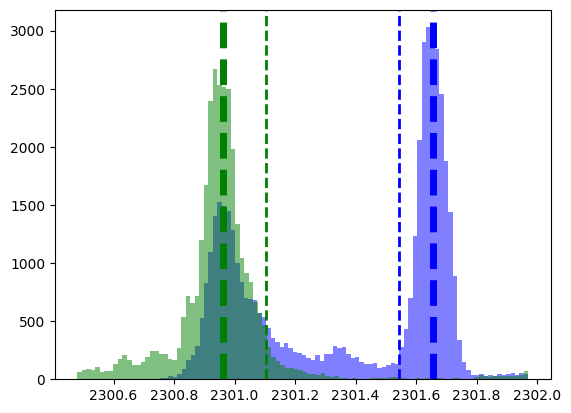

In [27]:
# plot medians of the gaussian components
plt.hist(two_returns_1[:,index], bins=100, color='blue', alpha=0.5)
plt.hist(two_returns_2[:,index], bins=100, color='green', alpha=0.5)
plt.axvline(two_returns_1_low, color='blue', linestyle='dashed', linewidth=2)
#plt.axvline(two_returns_1_high, color='blue', linestyle='dashed', linewidth=2)
#plt.axvline(two_returns_2_low, color='green', linestyle='dashed', linewidth=2)
plt.axvline(two_returns_2_high, color='green', linestyle='dashed', linewidth=2)
plt.axvline(two_returns_1_best_mean, color='blue', linestyle='dashed', linewidth=5)
plt.axvline(two_returns_2_best_mean, color='green', linestyle='dashed', linewidth=5)
plt.show()

In [28]:
data = data_points

In [29]:
water_points = data[(data[:,index] > two_returns_1_low) & (data[:,index] < two_returns_1_high)]
ground_points = data[(data[:,index] < two_returns_2_high)]

In [30]:
plotter = pv.Plotter()
plotter.add_points(water_points[:,3:6], color = 'blue', point_size=1)
plotter.add_points(ground_points[:,3:6], color = 'green', point_size=1)
plotter.add_mesh(plane, color='gray')
plotter.show()

Widget(value='<iframe src="http://localhost:33657/index.html?ui=P_0x7aa55b7176e0_3&reconnect=auto" class="pyvi…

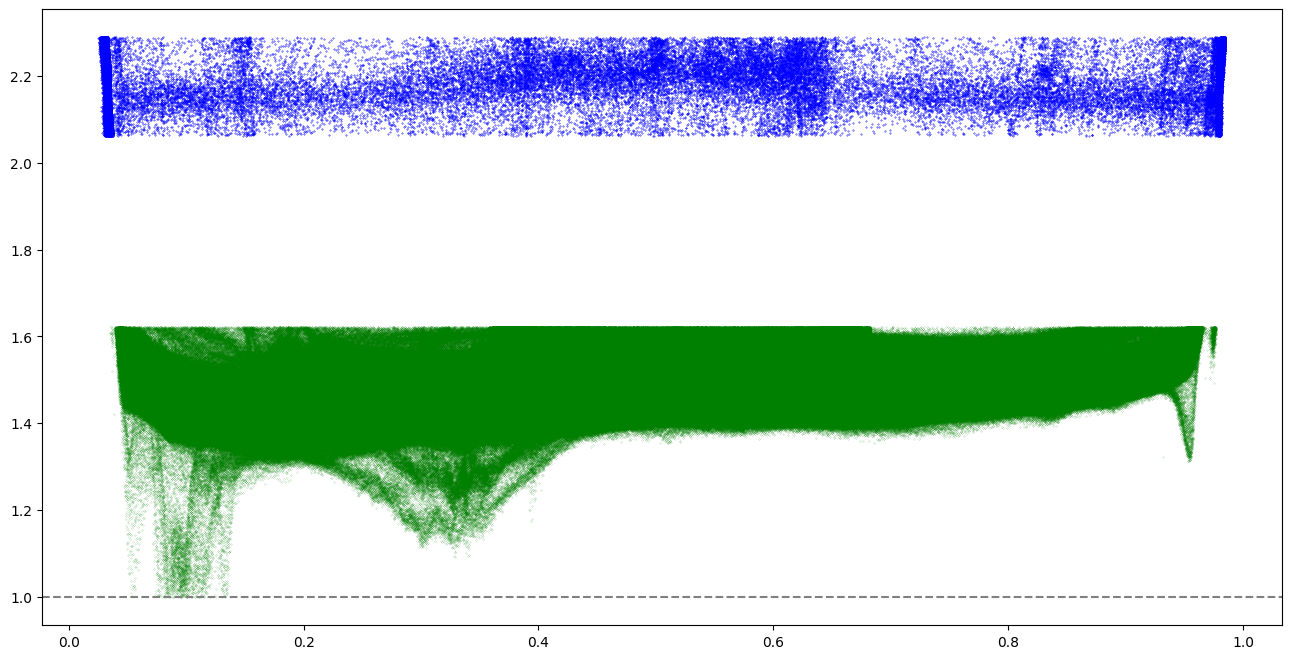

In [31]:
plt.figure(figsize=(16,8))
#plt.scatter(other_points_above[:,3], other_points_above[:,5]*(z_max-z_min), c='red', s=0.01)
plt.scatter(ground_points[:,3], ground_points[:,5]*(z_max-z_min), c='green', s=0.01)
plt.scatter(water_points[:,3], water_points[:,5] *(z_max-z_min), c='blue', s=0.1)
# plot bottom_pool_norm
plt.axhline(bottom_pool_norm*(z_max-z_min), color='gray', linestyle='--', label='Bottom pool')
plt.show()  

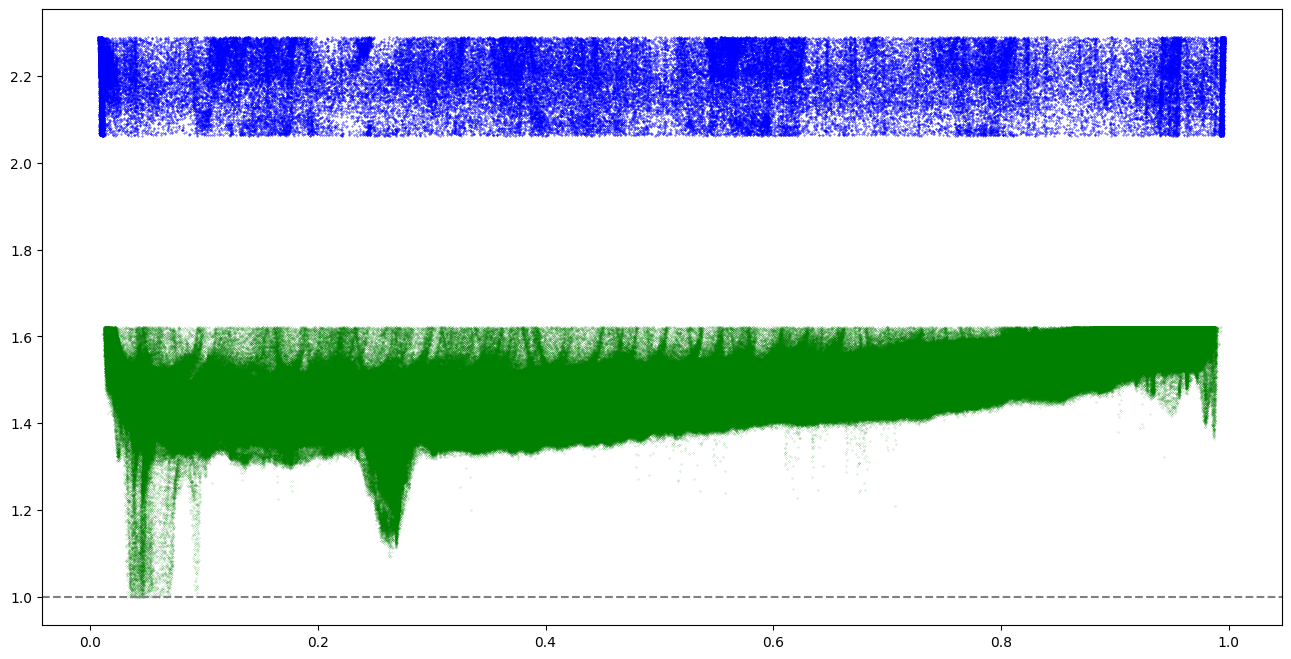

In [32]:
plt.figure(figsize=(16,8))
#plt.scatter(other_points_above[:,4], other_points_above[:,5]*(z_max-z_min), c='red', s=0.01)
plt.scatter(ground_points[:,4], ground_points[:,5]*(z_max-z_min), c='green', s=0.01)
plt.scatter(water_points[:,4], water_points[:,5] *(z_max-z_min), c='blue', s=0.1)
# plot bottom_pool_norm
plt.axhline(bottom_pool_norm*(z_max-z_min), color='gray', linestyle='--', label='Bottom pool')
plt.show()  

In [33]:
points_below = ground_points[:,3:6]

# Calcular las diagonales principales y secundarias
x_min_below = np.min(points_below[:, 0])
x_max_below = np.max(points_below[:, 0])
y_min_below = np.min(points_below[:, 1])
y_max_below = np.max(points_below[:, 1])

# Diagonal principal (de (x_min, y_min) a (x_max, y_max))>
diagonal1 = np.array([x_min_below, y_min_below, 0]), np.array([x_max_below, y_max_below, 0])

# Diagonal secundaria (de (x_min, y_max) a (x_max, y_min))
diagonal2 = np.array([x_min_below, y_max_below, 0]), np.array([x_max_below, y_min_below, 0])

# Función para calcular la distancia de un punto a una línea
def distance_to_line(points, line_start, line_end):
    x0, y0, z0 = points[:, 0], points[:, 1], points[:, 2]
    x1, y1, z1 = line_start
    x2, y2, z2 = line_end
    numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

# Umbral de distancia para considerar que un punto está en la diagonal
threshold = 0.01

# Identificar los puntos que pertenecen a las diagonales
distances_diagonal1 = distance_to_line(points_below, diagonal1[0], diagonal1[1])
distances_diagonal2 = distance_to_line(points_below, diagonal2[0], diagonal2[1])

points_on_diagonal1 = points_below[distances_diagonal1 < threshold]
points_on_diagonal2 = points_below[distances_diagonal2 < threshold]

mask_on_diagonal1 = remove_low_density_points(points_on_diagonal1, radius=threshold, min_neighbors=10)
mask_on_diagonal2 = remove_low_density_points(points_on_diagonal2, radius=threshold, min_neighbors=10)

points_on_diagonal1 = points_on_diagonal1[mask_on_diagonal1]
points_on_diagonal2 = points_on_diagonal2[mask_on_diagonal2]


# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos en las diagonales en azul
points_on_diagonal1_pv = pv.PolyData(points_on_diagonal1)
points_on_diagonal2_pv = pv.PolyData(points_on_diagonal2)
plotter.add_points(points_on_diagonal1_pv, color='blue', point_size=10)
plotter.add_points(points_on_diagonal2_pv, color='red', point_size=10)

# Añadir pool_bottom_norm
plane = pv.StructuredGrid(X, Y, Z)
plotter.add_mesh(plane, color='gray', opacity=0.5)

# Mostrar el plotter
plotter.show()

Widget(value='<iframe src="http://localhost:33657/index.html?ui=P_0x7aa54e71be90_4&reconnect=auto" class="pyvi…

Height water: 0.22518518495512074
Height water: 2301.685499997748


/home/diego/workspace/SQM/sqm_batimetria/venv/lib/python3.12/site-packages/numpy/polynomial/polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/diego/workspace/SQM/sqm_batimetria/venv/lib/python3.12/site-packages/numpy/polynomial/polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


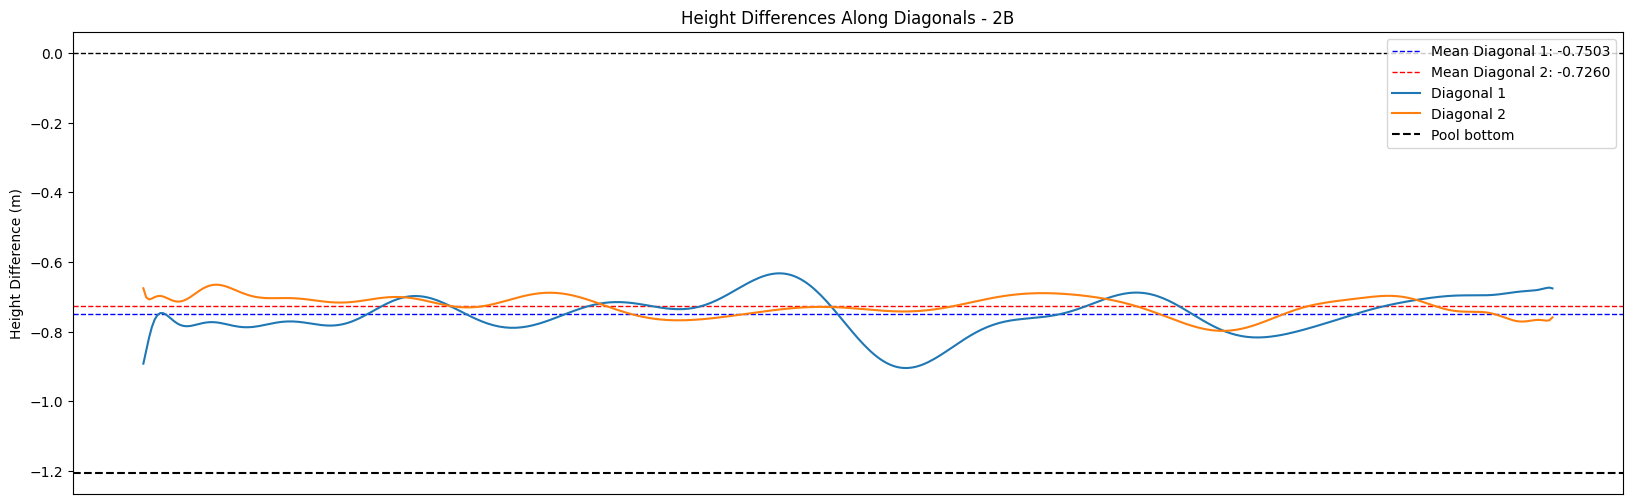

In [34]:
height_water = np.percentile(water_points[:,5], 50)
print(f"Height water: {height_water}")
print(f"Height water: {height_water*(z_max-z_min)+z_min}")

z_d1 = (height_water - points_on_diagonal1[:,2]) * (z_max - z_min) * -1
z_d2 = (height_water - points_on_diagonal2[:,2]) * (z_max - z_min) * -1
z_d2 = z_d2[::-1]

bottom_pool_norm_height = (height_water - bottom_pool_norm) * (z_max - z_min) * -1

degree = 30
poly_d1 = Polynomial.fit(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, degree)
poly_d2 = Polynomial.fit(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, degree)

x_new_d1 = np.linspace(0, 1, 500)
x_new_d2 = np.linspace(0, 1, 500)
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1)
mean_diagonal2 = np.mean(z_d2)

plt.figure(figsize=(20, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
plt.plot(x_new_d1, z_new_d1, label='Diagonal 1')
plt.plot(x_new_d2, z_new_d2, label='Diagonal 2')
# add bottom pool norm
plt.axhline(bottom_pool_norm_height, color='black', linestyle='--', label='Pool bottom')
plt.ylabel('Height Difference (m)')
plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
plt.xticks([])
plt.legend()
plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
plt.show()

In [34]:
z_points = (height_water - points_below[:,2]) * (z_max - z_min) * -1 
depth_mean_pool = np.mean(z_points)
print(round(depth_mean_pool,3))

-0.719


In [35]:
salt_z_points = ((((points_below[:,2]) * (z_max - z_min)) + z_min) - bottom_pool)
salt_mean_height = np.mean(salt_z_points)
print(round(salt_mean_height,3))

0.487


In [36]:
import json

file = {
    "height_water_normalized": height_water,
    "depth_pool": {
        "mean" :depth_mean_pool,
        "unit": "[m]"
    },
    "denormalize" : {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max
    },
    "diagonal1" : {
        "unit": "[m]",
        "mean": mean_diagonal1,
        "x_axis": x_new_d1.tolist(),
        "y_axis": z_new_d1.tolist(),
    },
    "diagonal2" : {
        "unit": "[m]",
        "mean": mean_diagonal2,
        "x_axis": x_new_d2.tolist(),
        "y_axis": z_new_d2.tolist(),
    }
}

#with open(f'{OUTPUTS_PATH}/{POOL_NAME}.json', 'w') as json_file:
#    json.dump(file, json_file, indent=4)

Grid Resolution: 1024 x 1067


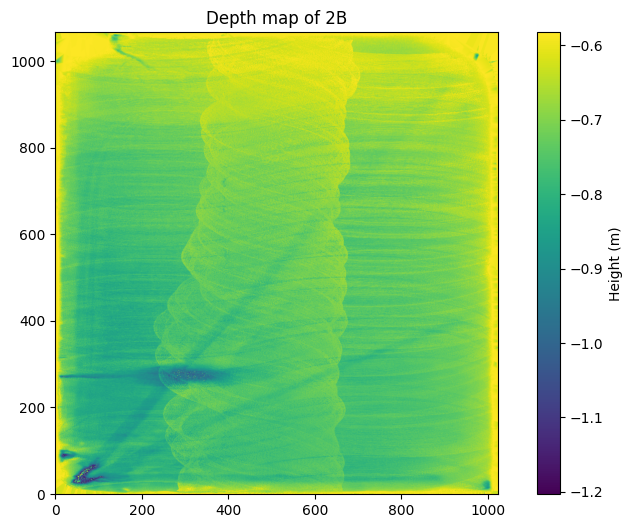

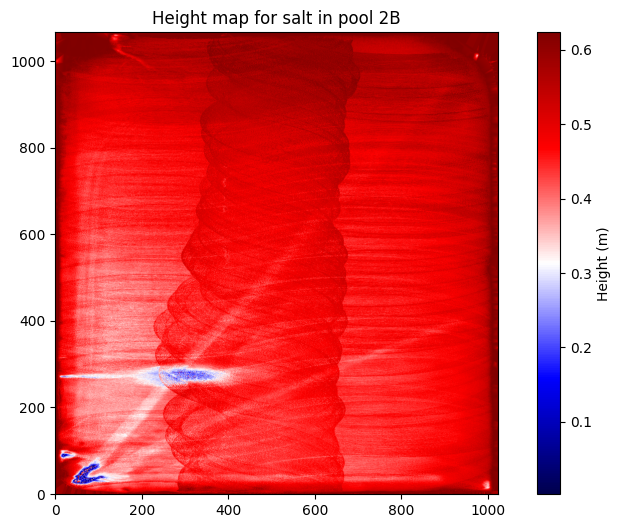

In [37]:
z = z_points 

x0, y0, z0 = water_points[:, 0], water_points[:, 1], water_points[:, 2]
x1, y1, z1 = points_below[:, 0], points_below[:, 1], points_below[:, 2]

grid_res_x = 1024  
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()

grid_res_y = int(grid_res_x * (y1_max - y1_min) / (x1_max - x1_min))
print(f"Grid Resolution: {grid_res_x} x {grid_res_y}")

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res_x),
    np.linspace(y1_min, y1_max, grid_res_y)
)

# First interpolation using linear method
grid_z_linear = griddata((x1, y1), z, (grid_x, grid_y), method="linear") 
grid_z_linear_for_salt = griddata((x1, y1), salt_z_points, (grid_x, grid_y), method="linear")

# Second interpolation using nearest method to ensure complete surface
grid_z_nearest = griddata((x1, y1), z, (grid_x, grid_y), method="nearest") 
grid_z_nearest_for_salt = griddata((x1, y1), salt_z_points, (grid_x, grid_y), method="nearest")

# Combine the results to ensure complete surface
grid_z = np.where(np.isnan(grid_z_linear), grid_z_nearest, grid_z_linear)
grid_z_for_salt = np.where(np.isnan(grid_z_linear_for_salt), grid_z_nearest_for_salt, grid_z_linear_for_salt)

# Plotting the combined result
plt.figure(figsize=(10, 6))
plt.imshow(grid_z, origin='lower', cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title(f'Depth map of {POOL_NAME}')
plt.show()

# Plotting the combined result
plt.figure(figsize=(10, 6))
plt.imshow(grid_z_for_salt, origin='lower', cmap='seismic')
plt.colorbar(label='Height (m)')
plt.title(f'Height map for salt in pool {POOL_NAME}')
plt.show()

In [38]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 
#cv2.imwrite(f'{OUTPUTS_PATH}/{POOL_NAME}.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'{OUTPUTS_PATH}/{POOL_NAME}.tiff')